# OONI Data Analysis

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

# Plotting Imports
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Statstools
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Plot configuration
sns.set_style('darkgrid')
sns.set_palette('tab10')
palette = sns.color_palette()

In [3]:
# Data paths
base_dir = '../results/'
hr_dir = os.path.join(base_dir, 'HR', 'processed')
hr_years = ['2021', '2022', '2023']
np_dir = os.path.join(base_dir, 'NP', 'processed')
np_years = ['2022']
by_dir = os.path.join(base_dir, 'BY', 'processed')
by_years = ['2022']

## 1 Introduction

For our project, we decided we wanted to study an learn more about censorship worldwide. In today's world, censorship is becoming more and more common. Many countries censor their political opponents, or censor criticism of themselves. We want to help combat this. Our project aims to do some small but significant work to help create a more open and free world.

## Dataset

*You must provide background on the dataset or datasets you
worked with, such as who created it, why, how it was collected, for what purpose
it was collected, what attributes are included, what representation decisions
were made and how that affects the data, etc. A good reference for questions
to ask about your data is the paper “Datasheets for Datasets,” by Gebru et al.
(2018) (https://arxiv.org/abs/1803.09010).*

Our dataset was created by the Open Observatory of Network Interference (OONI), a non-profit organization based in Italy focused on fighting internet censorship worldwide. The project was originally founded by The Tor Project, but now most of its funding comes from donations.

The dataset comes from the OONI Probe, a mobile app launched by OONI in 2017. At the time, it collected the largest dataset on internet censorship ever recorded. To this day, it remains the largest publicly available dataset on the topic. The app runs in the background on any phone that has it installed. OONI organizes coordinated tests, where phones in a specific region perform tests at the same time. These phones send internet requests to various sources, and the responses are reported back to a server at OONI’s headquarters. This process provides a broad overview of internet connectivity in regions with OONI app users. Researchers can analyze the data to identify sites and services that are consistently blocked, or use models to detect significant changes in internet access.

When sites are temporarily blocked, often due to political reasons, this is referred to as "temporal blocking." We chose this dataset to analyze after reading a paper (https://www.ndss-symposium.org/ndss-paper/modeling-and-detecting-internet-censorship-events/) that identified instances of temporal blocking in Nepal in 2022. Temporal blocking is a major challenge facing the free world. Smaller, and less indistrialized nations often get away with temporal blocking of political content around elections. Our goal for this project revolves around characterizing temporal censorship events.

The OONI probe performs at least 17 different types of tests. We won't go over all of them here, but we decided to focus on the web connectivity tests due to the large amount of data, and ease of interpretation. These tests first send out a DNS request for the targeted domain, and report if the DNS request returned as expected. If so, they then send out an HTTPS request to the domain, and record the response. This gives a broad view of whether citizens in a specific region are able to access content that OONI deems important or controversial. A control connection is also sent out at the same time called a "test helper". The responses of the test helper, and the tests are compared to create the final data point.

The web connectivity tests are massive. We started by trying to download certain chunks of data, and discovered that the data for the United States for one month was over 140 GB. The entire OONI database is several terabytes of data. We instead decided to focus on specific regions during the similar timeframes to perform our analysis. By narrowing our scope, we believe that we can do better work for this project. Due to the paper that we read, we started with Nepal 2022. We decided to analyze two other countries during the same timeframe, to use as points of comparison: Croatia and Belarus. We were looking for other small countries, and we wanted two countries on opposite sides of the censorship spectrum. Belarus is a well known censored country, and Croatia's constitution bans any form of internet censorship, thus they seemed like a perfect choice. Due to some issues with the dataset that we will discuss later, we ended up pivoting to focus on Croatia, and thus downloaded the Croatia 2021 and 2023 datasets as well to supplement our study.

In [4]:
# Load all datasets
web_data = {
    'hr' : {
        year : pd.read_csv(os.path.join(hr_dir, year, 'webconnectivity.csv')) for year in hr_years
    },
    'np' : {
        year : pd.read_csv(os.path.join(np_dir, year, 'webconnectivity.csv')) for year in np_years
    },
    'by' : {
        year : pd.read_csv(os.path.join(by_dir, year, 'webconnectivity.csv')) for year in by_years
    }
}

# Standardize URLs
def url_standardize(url):
    parsed = urlparse(url)
    b = parsed.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    d = parsed.path if parsed.path == "" or parsed.path[-1] != "/" else parsed.path[:-1]
    return c + d

# Loop through all datasets and clean
for country in web_data:
    for year in web_data[country]:
        wd = web_data[country][year]
        wd['date'] = pd.to_datetime(wd['date'])
        wd = wd.set_index('date')
        wd['input'] = wd['input'].map(url_standardize)
        web_data[country][year] = wd

The structure of the data is as follows. There are 18 different fields in the dataset:

- Date - when the test occured
- Probe_asn - what network the test occured in, using the unique Autonomous System number
- Status_code_match - whether the HTTPS status code matches between the test and control
- Resolver_asn - what network the DNS resolver contacted is located in
- X_null_null_flags - unused
- Body_length_match - whether the length of the response body match between the test and control
- DNS_consistency - whether the DNS resolution is consistent between the test and control
- Headers_match - whether the final response headers match between the test and control
- DNS_experiment_failure - describes the specific failures of any DNS request
- HTTP_experiment_failure - describes the specific failures of any HTTP request
- Body_proportion - The ratio of body lengths between the control and test response
- Title_match - whether the final response title matches between the test and control
- Blocking - says whether the domain has been judged to be blocked or not by OONI's algorithm
- Accessible - whether or not the final response was able to reach the requested domain
- X_dns_flags - unused
- Control_failure - describes the specific failures of any control request
- X_blocking_flags - unused
- input - the domain the test wanted to connect to


Example data (Nepal 2022):

In [5]:
# Show some example data
web_data['np']['2022']

,probe_asn,status_code_match,resolver_asn,x_null_null_flags,body_length_match,dns_consistency,headers_match,dns_experiment_failure,http_experiment_failure,body_proportion,title_match,blocking,accessible,x_dns_flags,control_failure,x_blocking_flags,input
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,fteproxy.org
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,sbc.net
2022-01-02,AS17501,True,AS17501,NaN,True,inconsistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,ecequality.org
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,episcopalchurch.org
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,0.999723,True,False,True,NaN,NaN,NaN,icrw.org
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,True,AS23752,NaN,True,consistent,True,NaN,NaN,0.975015,NaN,False,True,NaN,NaN,NaN,facebook.com
2022-12-31,AS23752,False,AS23752,NaN,NaN,consistent,True,NaN,NaN,0.000000,NaN,False,True,NaN,NaN,NaN,instagram.com
2022-12-31,AS23752,True,AS23752,NaN,NaN,consistent,True,NaN,NaN,0.000000,NaN,False,True,NaN,NaN,NaN,youtube.com


Of these fields, we care about 3 of them for our analysis: `date`, `input`, and `blocking`. Luckily for us, the `blocking` field already does all of the preprocessing we would need to detect blocking events. This field analyzes each of the other fields to tell us whether or not blocking has occurred, and what type of blocking the heuristics believe has occurred. The possible values are as follows:

In [6]:
# Show unique test types
event_types_disp = pd.Series(web_data['hr']['2022']['blocking'].sort_values().unique())
pd.DataFrame(event_types_disp, columns=['Blocking Type'])

,Blocking Type
0,False
1,dns
2,http-diff
3,http-failure
4,tcp_ip
5,NaN


These specific blocking test responses are:
* `False` - No blocking methods were detected
  * Either the site is accessible, or the site is inaccesible to both the test and control groups.
* `NaN` - The results of the test were inconclusive, and thus should be discarded
  * We ignore these in our visualization, and model creation.
* `dns` - The DNS server does not resolve the site properly, aka the DNS resolution differed between test and control
  * DNS is a service for translating domains to an IP address. It is the first step in any web access. It is commonly used as the first line of censorship. Groups will return a false IP address, or DNS error to implement censorship.
* `httpdiff` - The HTTP response differs between test and control.
  * This blocking type means that the request returned a block page to the user. The censoring group will analyze the destination IP address, or packet contents, and return a block page to deter the user from continuing to access this source.
* `httpfail` - The HTTP response returns with a failure error code, while the control does not
  * This blocking type means that the blocking entity intercepted the packet exactly as in the httpdiff failure, but instead of returning a block page returned an HTTP failure response code.
* `tcp` - The response returned with the TCP RST flag set to 1
  * This flag is supposed to be set when a failure occurs forcing all communication to halt. Censoring groups will use the flag to falsely force the machine to block, giving the view of a network failure to the user. The blocking entity intercepted the packet the same as the last 2 blocking types, but implements the response differently.


Most censored networks will use a mixture of all 4 blocking types to implement their censorship (dns, httpdiff, httpfail, tcp). A single event of any type does not necessarily mean blocking, but a large number of events in a similar timeframe likely mean blocking. Normally under 5% of events being blocked are not cause for concern.

So to recap, our dataset is the OONI censorship dataset for Croatia 2021-2023, Belarus for 2022, and Nepal for 2022. We are analyzing the blocking patterns during that time frame as a time series. We believe we can use this data to figure out more about temporal censorship in the world. But what specific questions do we want to answer?

## Questions

*You must clearly state the questions you’re attempting to answer.
Some questions could be a bit vague or broad, such as determining the basic
properties of the different attributes, but others should be more specific, such
as determining if a particular relationship exists.*

In our initial proposal, we set out a group of lofty goals to detect worldwide censorship. As we explored the data, and discovered its size, we decided to pivot. We wanted to narrow our scope, and discover more about specific regions of the world. We decided to analyze Nepal, Croatia, and Belarus as stated. We wanted to answer these 6 questions about at least 1 country. We eventually decided on these questions for Croatia specifically.

-----------------------------------------------------------------


1. What years of data have anomalies worth spending time on?

2. What date ranges are truly anomalous within our dataset?

3. What is happening inside of our anomalous date ranges?

4. What is being blocked in these date ranges, that is not outside of the ranges?

5. Are these differences statistically significant?

6. How do the different countries compare to each other in terms of blocking events?


We believe that these questions are significant, and worth our time.

## Visualizations

*An essential part of data science is visualization, to understand
the data. R makes some of this easy, through powerful plotting tools. You can
easily view scatterplots of all pairs of variables with the pairs function, you can
generate plots or histograms for individual variables, and many more complex
visualizations are available in other R packages. ggplot2 is particularly powerful.
1*
You can learn more R techniques for manipulating, visualizing, and presenting
data in the free book “R for Data Science” (https://r4ds.had.co.nz/).

To start our data exploration phase, we made a series of simple graphs showing the blocking events throughout time during 2022. 

The first graph shows the fraction of total events in each blocking class over time. The x axis is time, and the y axis is the proportion of events that came back with each class. It is a stackplot, which helps us view the total blocking events for a time period. The plot uses a 7 day rolling window to smooth out the plot, while still giving us the important trends. The legend shows which colors apply to which blocking event type. We are not using the NaN blocking events, as they are inconclusive, and usually are the result of a glitch with OONI's system. We can use this to see how total events change over time.

The second graph shows similar information, but in a different way. This graph shows the same time proportions as above, but not as a stackplot. This plot helps us see how the events proportionality relates to each other.

In [7]:
event_types = pd.Series(web_data['hr']['2022']['blocking'].dropna().sort_values().unique())

In [8]:
# Filter data into specific blocking methods
blocking_events = {
    country : {
        year : {
            event_type: web_data[country][year][web_data[country][year]['blocking'] == event_type]
            for event_type in event_types
        } for year in web_data[country]
    } for country in web_data
}

In [9]:
# Compute rolling totals, means, and standard deviations
k=7
totals = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
means = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
stds = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quarts = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quants = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
for country in blocking_events:
    for year in blocking_events[country]:
        for event_type in blocking_events[country][year]:
            # Calculate date range
            date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

            # Fill all empty events with zeroes
            d = blocking_events[country][year][event_type]
            tmp = d.groupby(d.index).size()
            totals[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()
            means[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().dropna()
            stds[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).std().dropna()
            quarts[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.25, 0.75]).dropna()
            quants[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.01, 0.1, 0.9, 0.99]).dropna()

In [10]:
# Calculate fractional events
fracs = {country : { year : {} for year in totals[country] } for country in totals}
for country in totals:
    for year in totals[country]:
        # Calculate fractional of all possible events
        d = pd.DataFrame(totals[country][year])
        tsum = d.sum(axis=1)
        fracs[country][year] =  d.div(tsum, axis=0).fillna(0)

In [11]:
def make_basic_visualization(country, year):
    # Select a country and year
    f = fracs[country][year]
    f = f[f.columns[f.columns != 'False']]
    ft = [f[c] for c in f.columns.sort_values()]

    temp_country = ""
    if country == "np":
        temp_country = "Nepal"
    elif country == "by":
        temp_country = "Belarus"
    elif country == "hr":
        temp_country = "Croatia"

    # Plot fractional events
    plt.figure()
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
    plt.legend()
    plt.grid()
    plt.title(f'Fractional Blocking Events For {temp_country} in {year} Over Time (k={k})')

    plt.figure()
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.plot(f, label=f.columns)
    plt.legend()
    plt.grid()
    plt.title(f'Mean and Standard Deviations of Blocking Events For {temp_country} in {year} (k={k})')
    plt.show()

##### Nepal 2022

-----------------------------------------------------------------

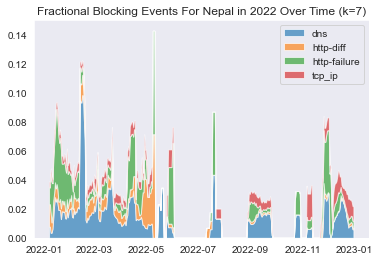

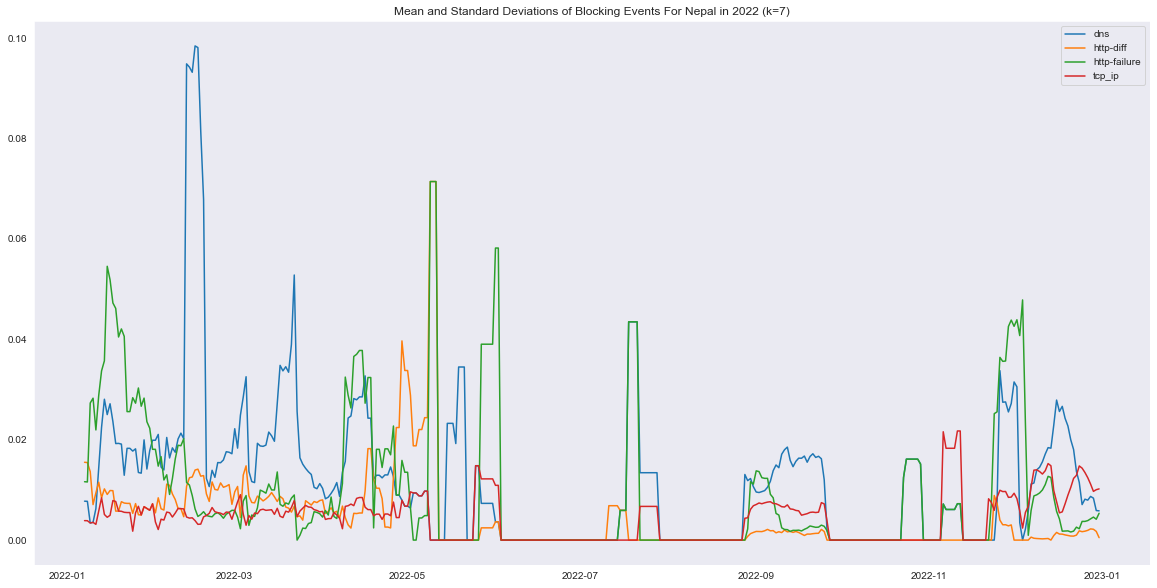

In [12]:
make_basic_visualization("np", "2022")

From this data, we see some interesting trends. The Nepal data is inconsistent. There are some obvious spikes, and some obvious valleys, but they don't tell us the whole story. There's some periods of time which don't have data. There are several weeks at a time which have no data. This makes analyzing this dataset difficult. There are also large gaps in the data even during the ful time. During the first several months, most data is nearly a week apart from each other. This hurts the readability of the data even more. There appears to be some level of censorship going on in the early months (which is when it was reported to happen), but the gaps make definitive conclusions impossible. Due to these gaps, we decided to look at our other countries/years for our analysis.

##### Belarus 2022

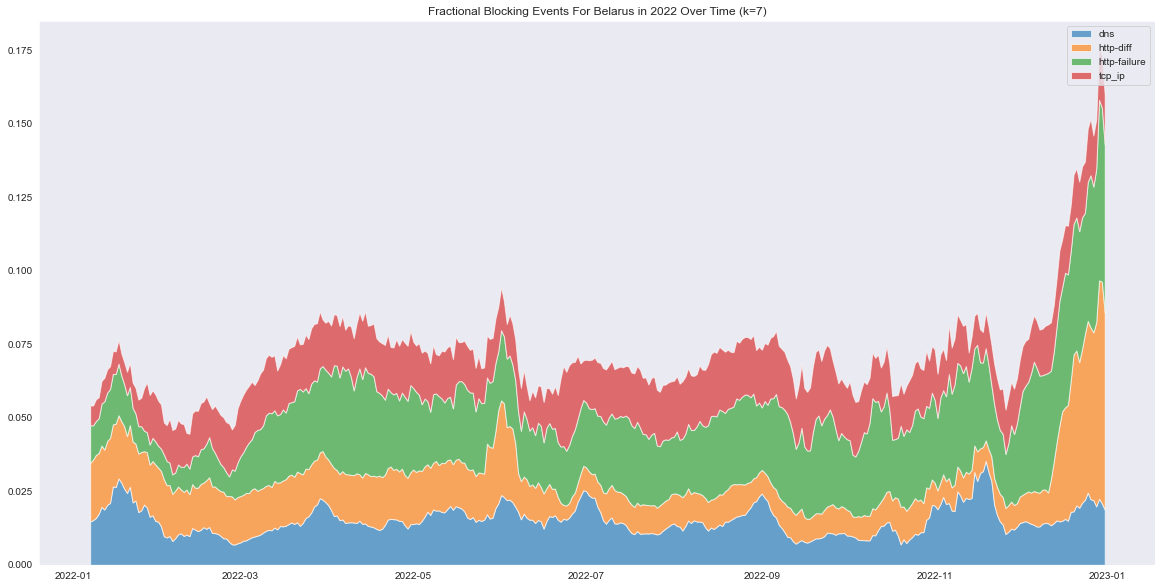

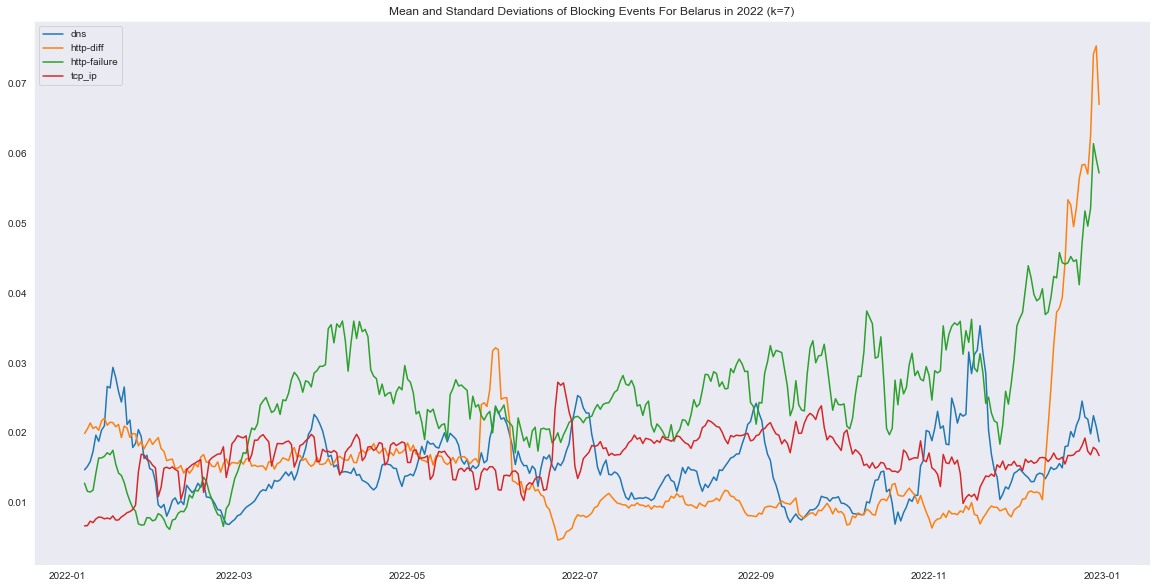

In [13]:
make_basic_visualization("by", "2022")

The Belarusian data gives us more of what we expect to see in a dataset. There is consistent data throughout the entire timeframe, making this a more useful dataset to analyze. Compared to Nepal, there is no periods of time without data. With Nepal, even periods with data had gaps of several days. Belarus is more consistent, thus we can do more analysis on these graphs.

Belarus is a country widely known for restrictions on the flow of information, so we predicted it to be fairly censored. The data was actually less censored than we expected it to be. Normally, around 7-8% of Belarus tests come back with a failure. This number does climb up all the way to nearly 17% during the end of year spike. This difference may have something to do with the Russian invasion of Ukraine, but this is not the main focus of our investigation. 

In Belarus, the majority of day-to-day censorship appears to be httpfailure type events, meaning Belarus primarily responds to packets by sending back an HTTP failure code. There are also large spikes of DNS failures, and httpdiff failures, but tcp errors do appear to be stable and low. This gives us some idea of the preffered methods of censorship by the Belarusian government. 

Overall, this is an interesting dataset to analyze, but we ended up not using it as our primary analysis. Belarus is a known restricted country, and showing that is not new information. The Belarusian data makes for a good point of comparison, but it is not the primary focus of this analysis. 



##### Croatia 2022

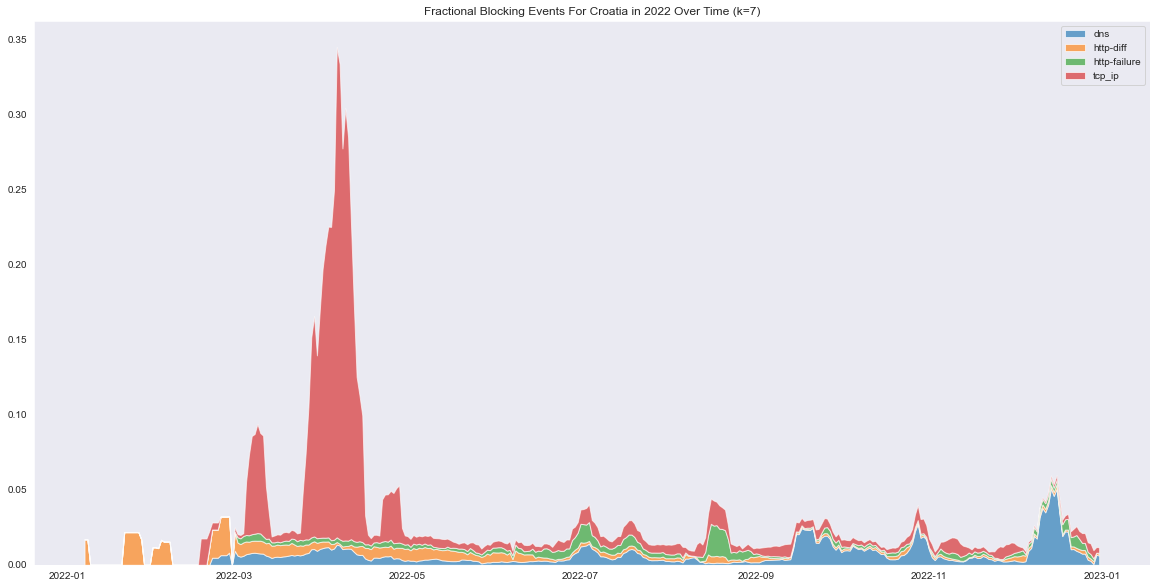

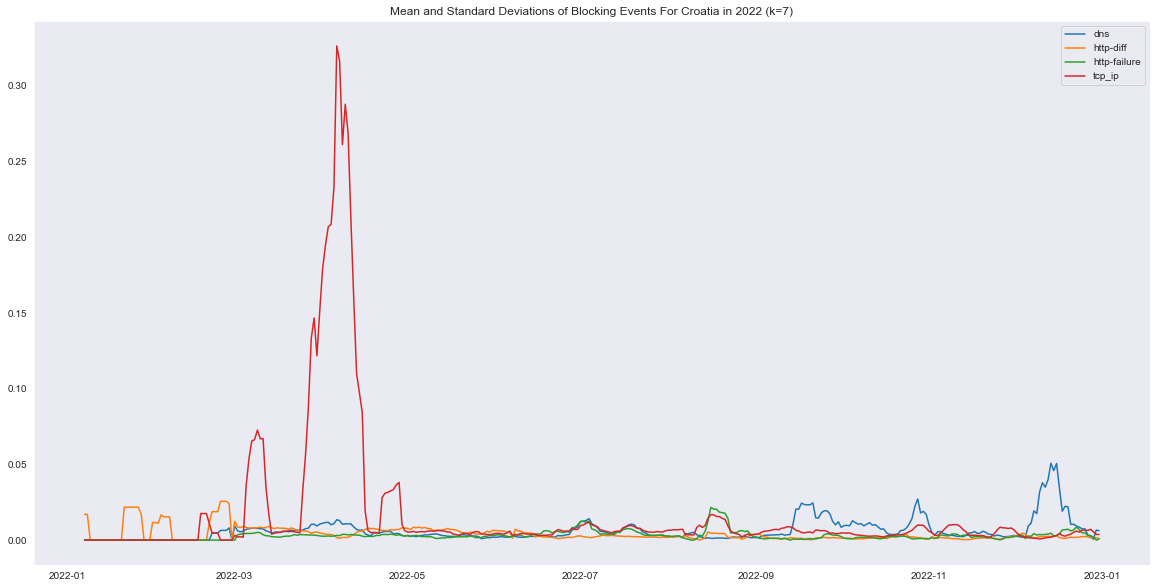

In [14]:
make_basic_visualization("hr", "2022")

Text(0.5, 1.0, 'Fractional Blocking Events For Croatia in 2022 Over Time (k=7)')

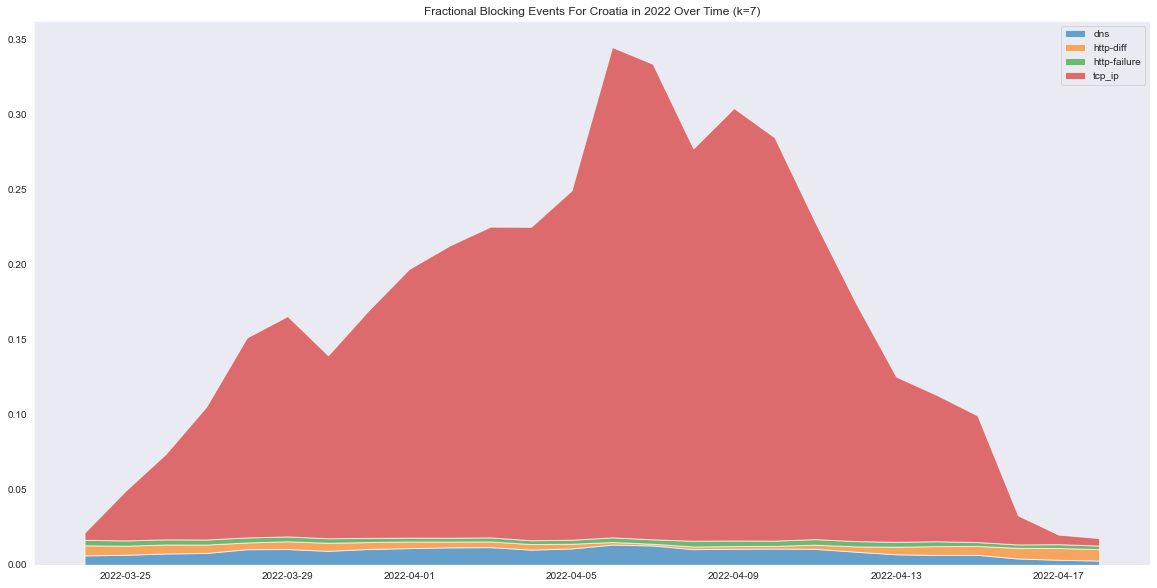

In [15]:
start_date = '2022-03-24'
end_date = '2022-04-18'
f = fracs["hr"]["2022"]
f.index = pd.to_datetime(f.index)
f = f[f.columns[f.columns != 'False']]
f = f[(f.index >= start_date) & (f.index <= end_date)]
ft = [f[c] for c in f.columns.sort_values()]


# Plot fractional events
plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]
plt.stackplot(ft[0].index, *ft, labels=f.columns.sort_values(), alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events For Croatia in {year} Over Time (k={k})')


This dataset has the most interesting anomaly that we found. Consistent data collection does not begin until March, but once March hits, we have a massive anomaly. Starting on about March 2nd, we begin a period of high blocking, which does not fully end until about April 30th. The peak of the event runs from March 24th until April 18th. During that timeframe, we have an absurdly high average blocking percentage. Almost the entire entire increase in blocking percentage is TCP/IP blocking (the blocking using a TCP RST flag). Something is happening here. Once we found this anomaly, we decided that it would be the center of our analysis. 

In [16]:
def calculate_mean(data):
    return (data.sum() - data["False"]) / data.sum()

In [17]:
blocking_start = "2022-03-24"
blocking_end = "2022-04-18"

curr_data = web_data["hr"]["2022"]

inner_range = (curr_data.index >= start_date) & (curr_data.index <= end_date)
outer_range = (curr_data.index < start_date) | (curr_data.index > end_date)

during = curr_data[inner_range].groupby('blocking').size()
outside = curr_data[outer_range].groupby('blocking').size()

print("Croatia 2022")
print(f"Blocking Percentage During Anomaly: {round(calculate_mean(during), 4)}")
print(f"Blocking Percentage Outside of Anomaly: {round(calculate_mean(outside), 4)}")

Croatia 2022
Blocking Percentage During Anomaly: 0.1586
Blocking Percentage Outside of Anomaly: 0.0216


As we can see, the percentage of blocked websites during the anomalies spike (March 24th - April 18th) jumps from 2.2% all the way to 15.9%. That kind of jump does not appear to be from random chance. We will discuss the statistical significance of this during the models section. 

In [18]:
temp = calculate_mean(web_data["np"]["2022"].groupby('blocking').size())
print(f"Blocking Percentage Nepal 2022: {round(temp, 4)}")
temp = calculate_mean(web_data["by"]["2022"].groupby('blocking').size())
print(f"Blocking Percentage Belarus 2022: {round(temp, 4)}")

Blocking Percentage Nepal 2022: 0.0365
Blocking Percentage Belarus 2022: 0.0713


These are the blocking percentages for Nepal and Belarus during that same year for reference. 

Due to the drastic increase in blocking compared to not only its own year, but Belarus, we decided to investigate further. Belarus and Croatia are close enough to each other within the internet, which means that significant outside network factors are unlikely to be the source of the anomaly. The only other options would be

1. A censorship event
2. An internal network failure

To see whether option 2 was likely or not, we decided to look at the difference in blocking percentage by domain. If the issue was an internal network failure, then all sites' blocking percentage would go up by a similar amount. If the percentage is inconsistent, that would lead us to believe that it was the result of firewall reconfiguration (whether intentional or accidental). So we created the figures below to analyze these differences.

In [19]:
# Calculate fraction of events blocked per input
def make_domain_graph(temp):
    baseline = temp.groupby('input').size()
    frac_dns_grouped = (temp[temp["blocking"] == "dns"].groupby('input').size() / baseline).dropna().sort_values(ascending=False)
    frac_httpdiff_grouped = (temp[temp["blocking"] == "http-diff"].groupby('input').size() / baseline).dropna().sort_values(ascending=False)
    frac_httpfail_grouped = (temp[temp["blocking"] == "http-failure"].groupby('input').size() / baseline).dropna().sort_values(ascending=False)
    frac_tcp_grouped = (temp[temp["blocking"] == "tcp_ip"].groupby('input').size() / baseline).dropna().sort_values(ascending=False)
    all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
    nn = 100
    top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
    top_n = all_grouped.loc[top_n_idx]
    c_top_n = top_n.cumsum(axis=1)
    plt.rcParams['figure.figsize'] = [5, 20]
    plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
    plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
    plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
    plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
    plt.margins(y=0)
    plt.legend()
    plt.grid()
    plt.title(f'Top {nn} Blocked Sites')
    plt.xlabel('Fraction of events')
    return all_grouped

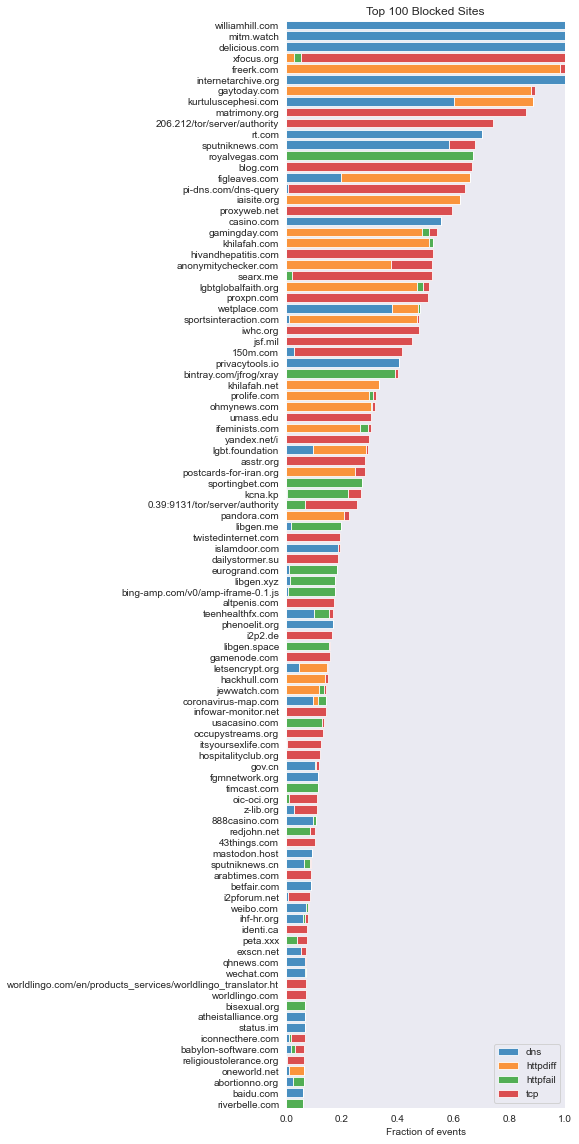

In [20]:
outer_grouped = make_domain_graph(web_data["hr"]["2022"][outer_range])

This plot shows us the top 100 most frequently blocked domains outside of the anomaly time. We can see that the 100th most blocked domain is blocked well under 10% of the time. This is a low blocking percentage. This shows that Croatia has some consistently blocked pages, but relatively few. 

Croatia's normal web blocking appears to use a mixture of all 4 blocking types.

DNS blocking appears to be used for "objectionable" websites. In Croatia's case, it is used for gambling sites (casino.com and williamhill.com), news services (sputniknews.com), a terrorist group's homepage (kurtuluscephesi.com), a bookmarking service (delicious.com, possibly defunct) and a man in the middle service (mitm.watch). By far the most confusing blocked site is internetarchive.org. This site is used to cache deleted webpages. We are not certain why this would be blocked.

Httpdiff seems to be primarily used for LGBTQ+ content, which Croatia blocks due to laws against LGBTQ+ individuals in the country (gaytoday.com and lgbtglobalfaith.org). It is also used for a website that we could not find any information on (freerk.org).

Httpfail is also used for primarily gambling services, though it is unclear why some services use DNS level blocking, and others use Httpfail type blocking (royalvegas.com, sportingbet.com).

Finally, the most interesting is the TCP level blocking, as the anomaly is primarily TCP level blocking. It also appears to be primarily blocking proxy services (tor, proxyweb.net) and "objectionable" content, such as dating services (matrimony.org), and sexual health related information (iwhc.org and hivandhepatitis.com)

It appears that certain websites are consistently blocked. Many of the blocked sites are focused on controversial topics (like LGBTQ+ topics), firewal bypassing services (like proxies), Russian media, and adult content/vices (casinos, adult videos, etc...). These are things commonly blocked by many countries, and not usually considered censorship. Nothing in this list stands out significantly. What is interesting is to then compare this to the top 100 blocked sites during the anomaly.

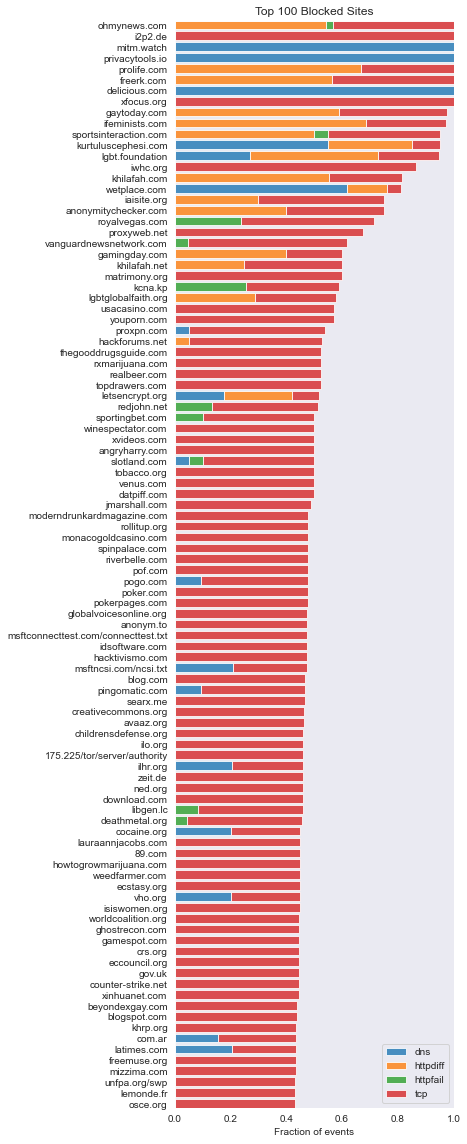

In [21]:
inner_grouped = make_domain_graph(web_data["hr"]["2022"][inner_range])

Obviously, a lot more of the internet is blocked here than it was before. In the outer range, the 100th most blocked site sits at around 5% blocking, which is most likely standard errors. Here, the 100th most blocked site is blocked over 40% of the time. That is a drastic difference. The majority of the increase is of course TCP level blocking. Despite this, it is hard to see what the most increased sites are. To more accurately analyze the difference, we've created a dataframe showing the sites with the highest difference in blocking percentage between inside and outside of the anomaly. 

In [22]:
# Get blocking events in small date range
summed = (inner_grouped - outer_grouped).sum(axis=1)
summed.to_frame("Summed").sort_values(by="Summed", ascending=False).head(30)

,Summed
input,
i2p2.de,0.835766
ohmynews.com,0.683486
prolife.com,0.678571
ifeminists.com,0.671265
lgbt.foundation,0.654279
vanguardnewsnetwork.com,0.603896
privacytools.io,0.595041
youporn.com,0.562254
rxmarijuana.com,0.515406


These represent the 30 sites with the biggest difference in blocking percentage inside and outside of our anomaly. They fit into a couple categories. 

* Proxies/Hacking/P2P Clients - These are a similar group of sites. All of these sites are ways for users to access content through non-standard channels. This is the most significant group. The single biggest increase is a P2P client (i2p2.de). Multiple of the largest increases belong to this group (i2p2.de, privacytools.io, hackforums.net, etc...)
* Abortion Discussion - Abortion is a heavily regulated procedure in Croatia, and thus it is logical that abortion discussion is heavily moderated. The banned sites are a mixture of pro-choice (ifeminist.org), and pro-life (prolife.com).
* News Sources - Multiple news sources are censored heavily during the anomaly. Most notably, we have a South Korean news source (ohmynews.com), and a major white supremacist news source (vanguardnewsnetwork.com). While the white supremacist news ban makes sense, there seems to be no major reason to ban the South Korean news source.
* Adult Entertainment - Many countries restrict adult media, and this is no exception. Adult video sites (xvideos.com, youporn.com, venus.com), and adult toy sites (topdrawer.com) are all blocked during this time period. 
* Gambling - Many gambling sites are restricted during the anomaly (datpiff.com, sportsinteraction.com, monacogoldcasino.com). Gambling was legalized a decade ago in Croatia, and is still controversial, making these bans unsurprising.
* Controlled Substance Sites - Many sites relating to controlled substances are inaccessible during this time (rxmarijuana.com, thegooddrugsguide.com, winespectator.com, tobacco.org)
* LGBTQ+ Organizations - Croatia does not allow gay marriage to this day, making bans on LGBTQ+ advocacy groups interesting, and worth investigation (lgbt.foundation)

Overall, the array of banned sites is wide, but all are sites that are commonly banned in countries with censorship in place. It is good for us to analyze which sites are banned, but we did not find anything surprising here. 

Due to this intriguing find with Croatia 2022, we decided to download Croatia 2021 and 2023 to compare against, and we will discuss them below.

##### Croatia 2021

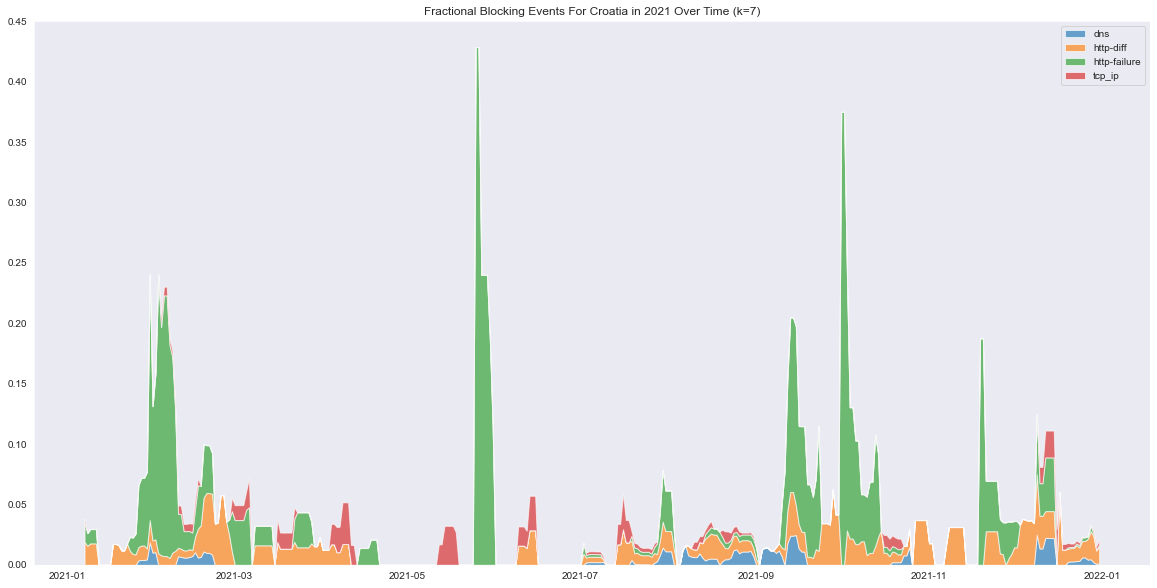

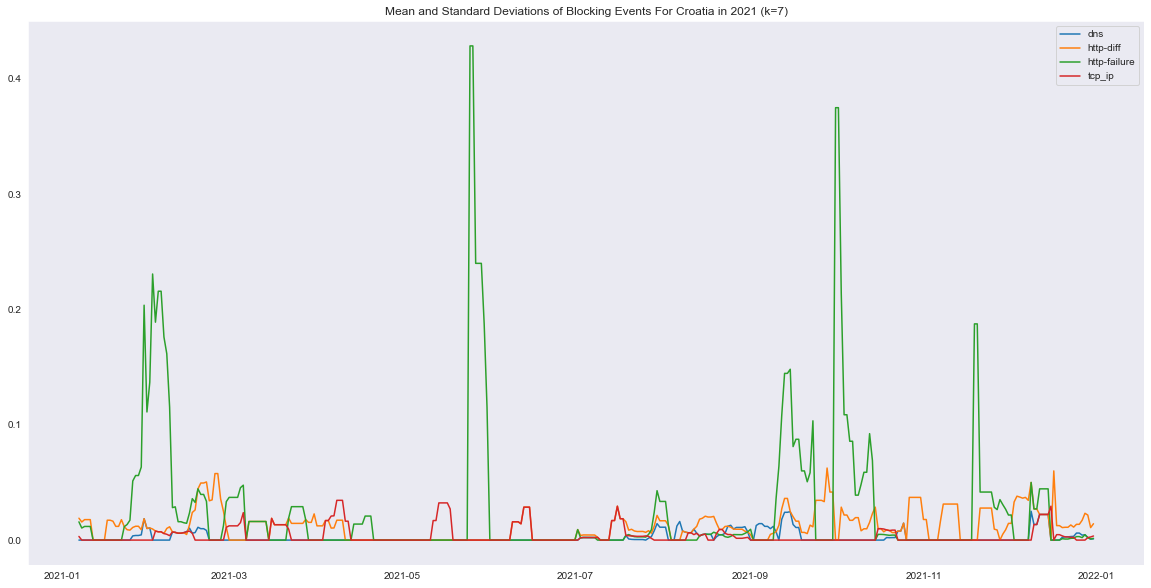

In [25]:
make_basic_visualization("hr", "2021")

With the 2021 data, we see many of the same issues that plagued the Nepal dataset. There are some obvious gaps, where no tests were run for several weeks at a time. This dataset has less gaps than nepal, but has enough to make the data less useful than it would otherwise be. We do however see some pretty significant spikes in httpfailure type blocking events. These spikes never last long, but do spike up beyond 35%, which is significant. If this dataset was more complete, it would be worthwhile to analyze. However, due to the sparse data collection, we will not analyze this dataset further.

##### Croatia 2023

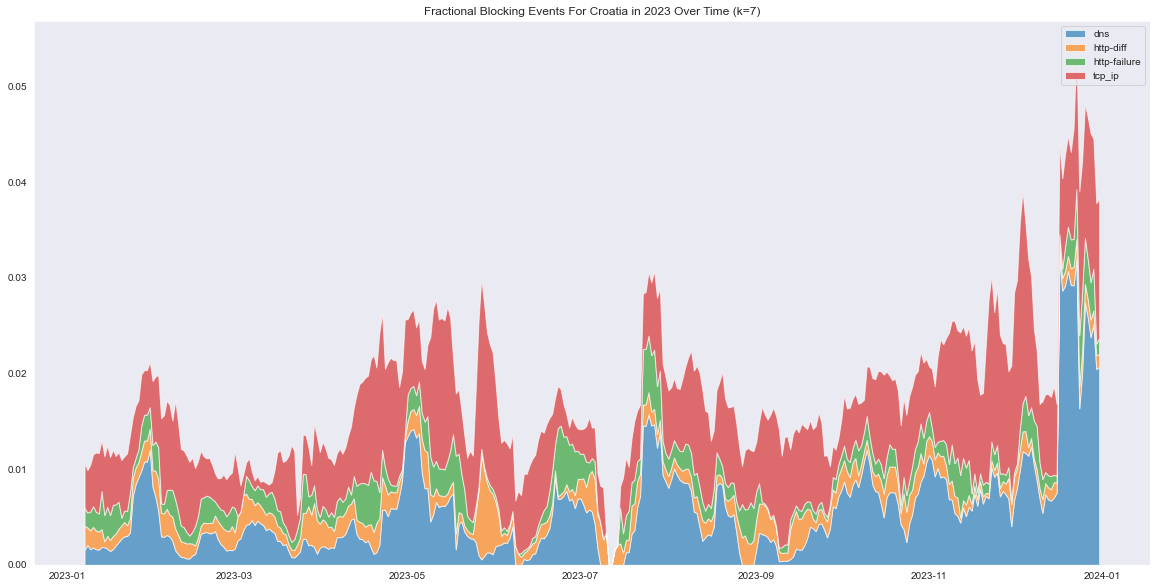

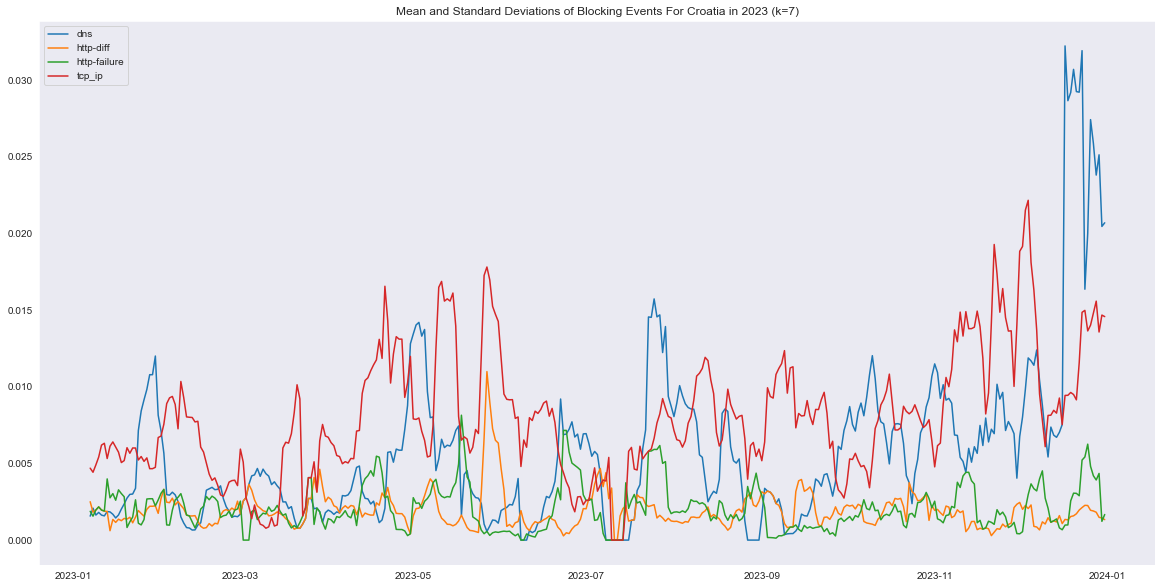

In [24]:
make_basic_visualization("hr", "2023")

In [26]:
temp = calculate_mean(web_data["hr"]["2023"].groupby('blocking').size())
print(f"Blocking Percentage Croatia 2022: {round(temp, 4)}")

Blocking Percentage Croatia 2022: 0.0194


This year of data is exactly what we expect to see out of a non-censored country. At worst, we see a 3% blocking percentage, and our average is under 2%. This is similar to our 2022 mean outside of the anomaly (1.94% vs 2.16%). This helps us see what the Croatian dataset should look like. There is no anomaly occurring during Spring of this year, which helps us show that the anomaly is truly unexpected. Something happened during that time that seemingly has not happened before or since. We want to figure out what it is. In the next section, we will go over some models we intend to use to analyze our model. 

## Models

*Your final project should include models and analysis, such as
comparisons and contrasts, checking for statistical significance (if/when appro-
priate), discussions of modeling assumptions and limitations, etc.*

##### Basic Anomaly Detection

First we try to find potential anomalies automatically using the $95\%$ quantile as a threshold for the mean blocking events.  This produces the following plot of potentially interesting regions of time to investigate further.

In [27]:
# Get the data of interest
country = 'hr'
year = '2022'
w = web_data[country][year]
f = fracs[country][year].drop('False', axis=1)

# Get means and standard deviations
m = pd.DataFrame(means[country][year])
m = m.reindex(sorted(m.columns), axis=1)
m = m.drop('False', axis=1)
s = pd.DataFrame(stds[country][year])
s = s.reindex(sorted(s.columns), axis=1)
s = s.drop('False', axis=1)

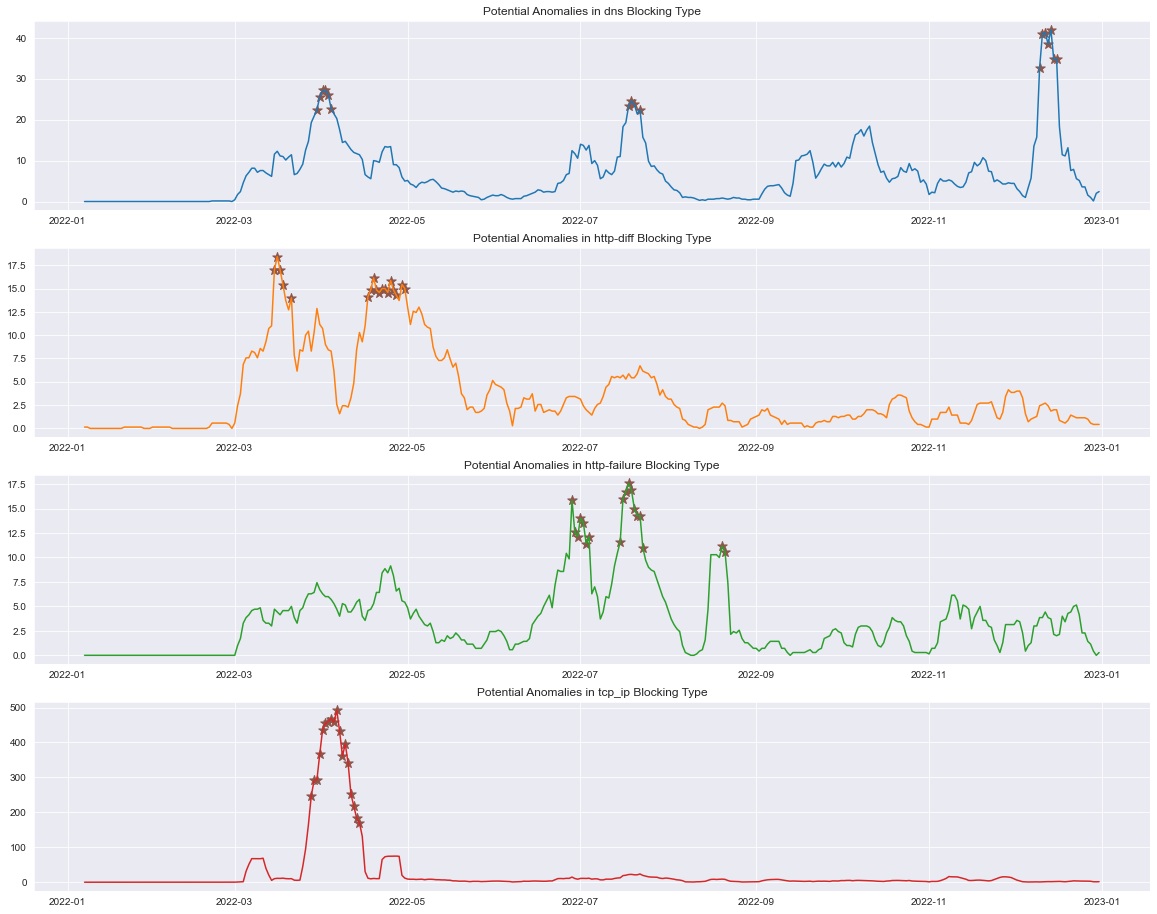

In [28]:
# Perform IQR checks on the mean
iqr = m.quantile([0.05, 0.95])
lb = iqr.iloc[0]
ub = iqr.iloc[1]

# Check for anomalies outside of ranges
au = (m > ub)
al = (m < lb)

# Plot anomalies
plt.figure(figsize=(20, 4*len(m.columns)))
for i, c in enumerate(m.columns):
    # Get color values
    #color = au[c].apply(lambda x: palette[len(m.columns)+1] if x is True else palette[i])
    anom = m[au]

    # Plot
    plt.subplot(len(m.columns), 1, i+1)
    plt.plot(m[c], label=c, color=palette[i])
    plt.scatter(anom.index, anom[c], s=100, color=palette[len(m.columns)+1], marker='*')
    plt.title(f'Potential Anomalies in {c} Blocking Type')
plt.show()

From these plots, we chose 3 date ranges of interest:

* (a) March 1st 2022 to April 30th 2022
* (b) June 15th 2022 to September 1st 2022
* (c) December 5th 2022 to December 31st 2022

##### Statistical Tests

Next we'd like to characterize the dataset and understand more what is happening inside of these regions of interest versus outside of the regions.  To do this we have to first check some basic statistical tests.

##### Z-Tests

In [29]:
# Define ranges
start_dateA = '2022-03-01'
end_dateA = '2022-04-30'
start_dateB = '2022-06-15'
end_dateB = '2022-09-01'
start_dateC = '2022-12-05'
end_dateC = '2022-12-31'

# Get indices
w_inner_idxA = (w.index >= start_dateA) & (w.index <= end_dateA)
m_inner_idxA = (m.index >= start_dateA) & (m.index <= end_dateA)
w_outer_idxA = ~w_inner_idxA
m_outer_idxA = ~m_inner_idxA

w_inner_idxB = (w.index >= start_dateB) & (w.index <= end_dateB)
m_inner_idxB = (m.index >= start_dateB) & (m.index <= end_dateB)
w_outer_idxB = ~w_inner_idxB
m_outer_idxB = ~m_inner_idxB

w_inner_idxC = (w.index >= start_dateC) & (w.index <= end_dateC)
m_inner_idxC = (m.index >= start_dateC) & (m.index <= end_dateC)
w_outer_idxC = ~w_inner_idxC
m_outer_idxC = ~m_inner_idxC

# Split data into ranges
w_innerA = w[w_inner_idxA]
m_innerA = m[m_inner_idxA]
w_outerA = w[w_outer_idxA]
m_outerA = m[m_outer_idxA]

w_innerB = w[w_inner_idxB]
m_innerB = m[m_inner_idxB]
w_outerB = w[w_outer_idxB]
m_outerB = m[m_outer_idxB]

w_innerC = w[w_inner_idxC]
m_innerC = m[m_inner_idxC]
w_outerC = w[w_outer_idxC]
m_outerC = m[m_outer_idxC]

First we perform a two sample Z-Test in order to determine if the mean values of each type of blocking method are different within each date range versus outside of each date range.

We run the Z-Test for date range **(a)** versus outside of the date range:

In [30]:
# Get the 2 Sample Z-Test
pd.DataFrame(ztest(m_innerA, m_outerA, value=0), index=['Z Statistic', 'p-value'], columns=m_innerA.columns)

,dns,http-diff,http-failure,tcp_ip
Z Statistic,6.041636e+00,1.880703e+01,4.169273,1.378721e+01
p-value,1.525592e-09,6.613715e-79,0.000031,3.043069e-43


Given that all of the blocking event types pass the p-value threshold of $0.05$, we can reject the null hypothesis that the distributions of these blocking events have the same means.  This likely means that the **(a)** date range distribution of blocking events are all distinct from other times throughout the year.

Next we run the Z-Test for the date range **(b)** versus outside of the date range:

In [31]:
# Get the 2 Sample Z-Test
pd.DataFrame(ztest(m_innerB, m_outerB, value=0), index=['Z Statistic', 'p-value'], columns=m_innerB.columns)

,dns,http-diff,http-failure,tcp_ip
Z Statistic,-0.453515,-1.926296,1.222851e+01,-2.230284
p-value,0.650178,0.054067,2.189270e-34,0.025729


Given that only the `http-failure` and `tcp_ip` blocking events pass the p-value threshold of $0.05$, we can only reject the null hypothesis that the distributions have the same means inside versus outside of the date range.

Finally we run the Z-Test for the date range **(c)** versus outside of the date range:

In [32]:
# Get the 2 Sample Z-Test
pd.DataFrame(ztest(m_innerC, m_outerC, value=0), index=['Z Statistic', 'p-value'], columns=m_innerC.columns)

,dns,http-diff,http-failure,tcp_ip
Z Statistic,6.296285e+00,-2.966596,-1.077220,-1.640400
p-value,3.048631e-10,0.003011,0.281382,0.100922


We can only reject the null hypothesis for the `http-diff` and `dns` blocking event types in this case, which matches our assumptions from the detected anomalies from above.

##### Time Series Characterization

Next we try to validate some properties about the time series itself, namely:

* Stationarity - Whether the data is not a function of time
* Autocorrelation - Whether the time series dataset has any lags which are related to the current time step
* Partial Autocorrelation - Whether the time series is related to its past values while controlling for intervening values which can indicate the influence of lagged observations on the current observation excluding other lags

To determine stationarity, we use the Augmented Dickey-Fuller test, which is a statistical test that tries to evaluate whether the null hypothesis that a particular time series dataset is non-stationary, meaning that the data is a function of time. If the test's p-value is below a significance threshold, we can reject this and assume our data is stationary, which makes modeling the relationship a bit less complicated.

In [33]:
# Compute rolling totals, means, and standard deviations
k=1
totals1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
means1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
stds1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quarts1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
quants1 = {country : { year : {} for year in blocking_events[country] } for country in blocking_events}
for country in blocking_events:
    for year in blocking_events[country]:
        for event_type in blocking_events[country][year]:
            # Calculate date range
            date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

            # Fill all empty events with zeroes
            d = blocking_events[country][year][event_type]
            tmp = d.groupby(d.index).size()
            totals1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).sum().dropna()
            means1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().dropna()
            stds1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).std().dropna()
            quarts1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.25, 0.75]).dropna()
            quants1[country][year][event_type] = tmp.copy().reindex(date_range, fill_value=0).rolling(window=k).mean().quantile([0.01, 0.1, 0.9, 0.99]).dropna()

In [34]:
# Compute ADF
t = totals1['hr']['2022']
tdf = pd.DataFrame(t).drop('False', axis=1)
adf_tests = { typ : [adfuller(t[typ])[0], adfuller(t[typ])[1]] for typ in blocking_events['hr']['2022'] if typ not in ['False']}
pd.DataFrame(adf_tests, index=['ADF Statistic', 'p-value'])

,dns,http-diff,http-failure,tcp_ip
ADF Statistic,-5.462238,-2.93027,-4.336395,-2.706767
p-value,0.000003,0.04194,0.000384,0.072875


Since the p-values of all of the blocking events except for `tcp_ip` is below the threshold $0.05$, then we can safely reject the null hypothesis that the time series data is non-stationary in those specific cases.  This means that the data in the other blocking event types is likely to be stationary in the 0th order.  For `tcp_ip` more analysis is necessary to determine its characteristics.

In order to determine what point that the `tcp_ip` blocking events become stationary, we use the 1st order and 2nd order differential tests and the autorrelation of those.

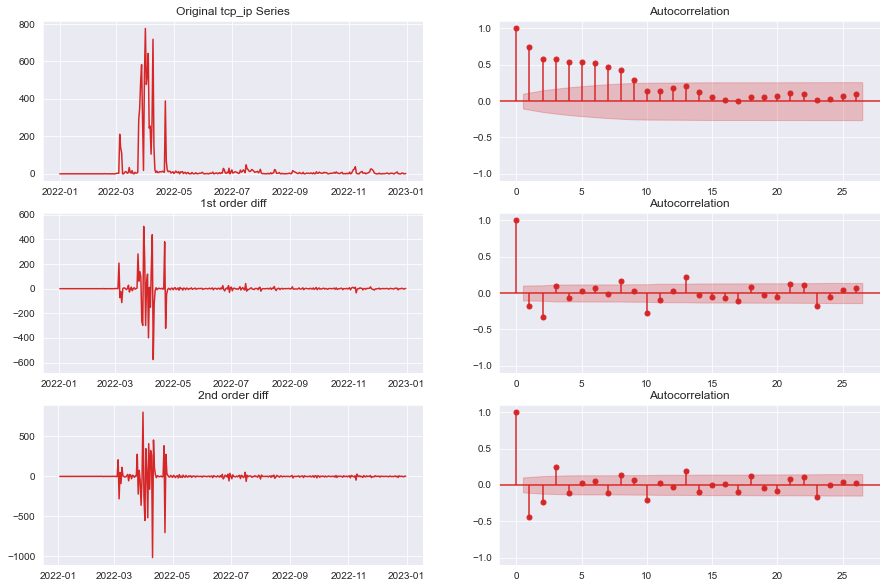

In [35]:
# Set plot options
plt.rcParams['figure.figsize'] = [15, 10]
color = palette[len(tdf.columns)-1]

# Calculate differentials
diff_0 = tdf['tcp_ip']
diff_1 = diff_0.diff().dropna()
diff_2 = diff_1.diff().dropna()

# Plot all differentials and their autocorrelation
fig, axes = plt.subplots(3,2, sharex=False)
axes[0, 0].plot(diff_0, color=color)
axes[0, 0].set_title('Original tcp_ip Series')
plot_acf(diff_0, ax=axes[0, 1])
axes[0, 1].set_ylim(-1.1, 1.1)

# 1st order differencing
axes[1, 0].plot(diff_1, color=color)
axes[1, 0].set_title('1st order diff')
axes[1, 0].set_ymargin(0.1)
plot_acf(diff_1, ax=axes[1, 1])
axes[1, 1].set_ylim(-1.1, 1.1)

# 2nd order differencing
axes[2, 0].plot(diff_2, color=color)
axes[2, 0].set_title('2nd order diff')
plot_acf(diff_2, ax=axes[2, 1])
axes[2,1].set_ylim(-1.1, 1.1)

for i in range(0,3):
    for line in axes[i,1].get_lines():
        line.set_color(color)
    for marker in axes[i,1].collections:
        marker.set_color(color)

# Show the plot
plt.show()

From these graphs we can conclude that the data becomes stationary likely at its 1st order differential given that the peaks in the autocorrelation factor plot settle close to the threshold very quickly.

Next we run autocorrelation and  partial autocorrelation factor analysis on the rest of the raw totals to see what types of intra-series relationships there are.

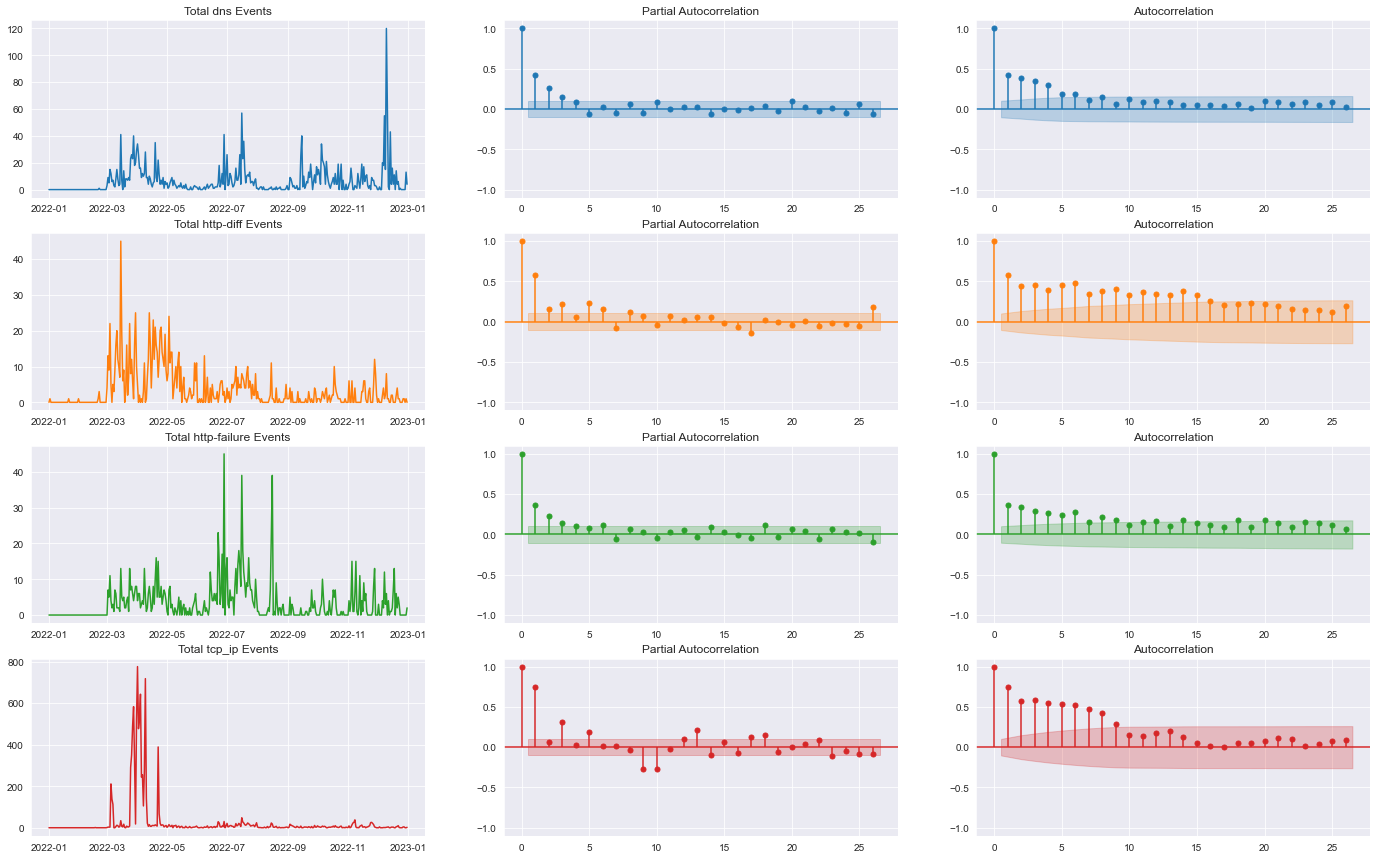

In [36]:
# Set plot options
plt.rcParams['figure.figsize'] = [len(tdf.columns)*6, 15]

# Plot
fig, axes = plt.subplots(len(tdf.columns), 3, sharex=False)
for i, t in enumerate(tdf.columns):
    axes[i,0].plot(tdf[t], color=palette[i])
    axes[i,0].set_title(f'Total {t} Events')
    plot_pacf(tdf[t].dropna(), ax=axes[i,1], color=palette[i])
    axes[i,1].set(ylim=(-1.1,1.1))
    plot_acf(tdf[t].dropna(), ax=axes[i,2], color=palette[i])
    axes[i,2].set(ylim=(-1.1, 1.1))
    for j in range(1,3):
        for line in axes[i,j].get_lines():
            line.set_color(palette[i])
        for marker in axes[i,j].collections:
            marker.set_color(palette[i])
plt.show()

From these plots we can see that most of the models have 1st, 2nd, and 3rd order partial autocorrelation factors above the threshold of acceptance, likely meaning that there is some intra-day relationships from past days up to those size windows.  None of the blocking events seem to indicate that they have any seasonality due to the fact that there is steady dropoff without any regular peaks.  It is also interesting to see that `tcp-ip` has peaks at orders 1, 3, 5, 9, and 10 which are potential parameters to try during modeling.

In terms of the Z-Test that was done earlier, there are limits on what conclusions can be drawn due to the fact that all of the blocking events are not exactly independently distributed, however due to the fact that the autocorrelation drops of farily steadily in all cases, it can be concluded that statistically it is likely for the different date ranges to actually have the differences from the means that we observed. 

As for autocorrelation, most of the different events have steady decline in autocorrelation, meaning that the series may have fairly short term memory of its events.  There do not seem to be any strong trends or seasonal patterns which seems consistent with just visual inspection of the data as well.

##### Time Series Modeling

Now that we have characterized the data iself, we would like to build models of the data using the Auto Regressive Integrated Moving Average method (ARIMA).  This method is split into 3 different parts:

* `p` - The autoregressive (AR) term refers to the order in which the model depends on a specific lag factor
* `d` - The integration (I) term refers to which order that the data is stationary in
* `q` - The moving average (MA) term refers to where the output depends only on lagged errors

For every blocking event except `tcp_ip` we are assuming the data to be stationary which means its `d` term is nonzero (and from our previous explorations we've determined it is likely $d=1$).

We test a few different models for each method and compare their AIC and BIC values.

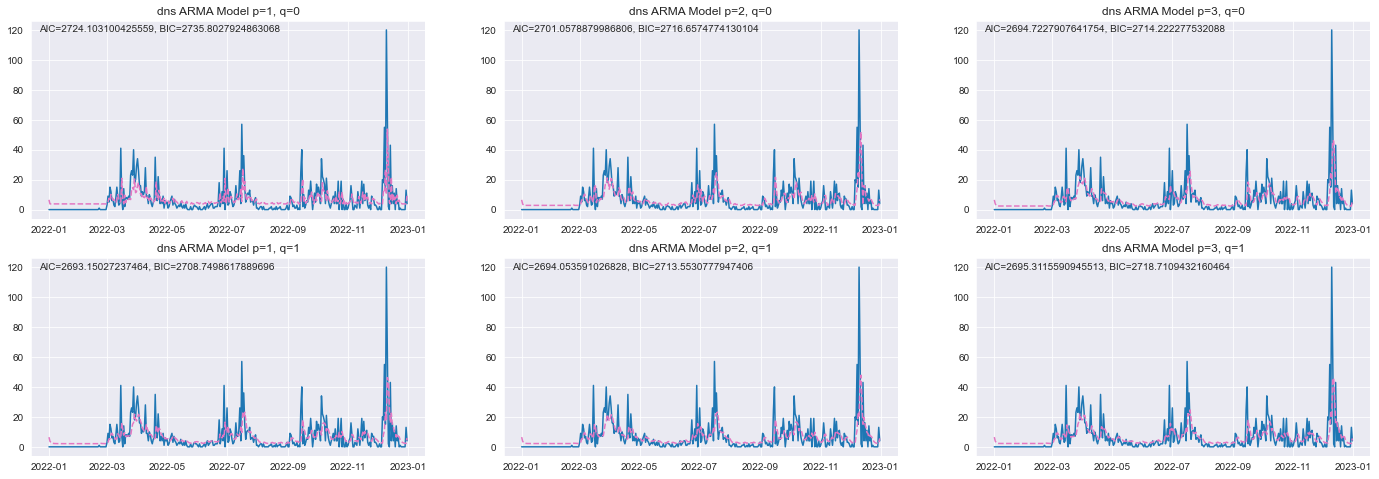

In [37]:
# Try out different ARMA terms
ar_orders = [1,2,3]
ma_orders = [0,1]

# Type and color
i = 0
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 0, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From this exploration of model parameters, we can see that the model with the lowest AIC as well as BIC is the model with $p=1$, $q=1$.  This likely means that first order auto regression and first order moving average are decent predictors of future behavior in the `dns` data (therefore a period of 1 day likely predicts the next day).

In [38]:
fitted_models[1][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    dns   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1342.575
Date:                Mon, 17 Mar 2025   AIC                           2693.150
Time:                        02:24:36   BIC                           2708.750
Sample:                    01-01-2022   HQIC                          2699.350
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4474      2.522      2.556      0.011       1.503      11.391
ar.L1          0.8584      0.031     27.325      0.000       0.797       0.920
ma.L1         -0.5676      0.048    -11.766      0.000      -0.662      -0.473
sigma2        91.6184      2.054     44.615      0.000      87.594      95.643
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):             23501.89
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               4.08   Skew:                             4.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For the `http-diff` blocking events, we see that there are peaks in the partial autocorrelation function plots at 1,3,5, and 6, so we test these values for the AR orders.

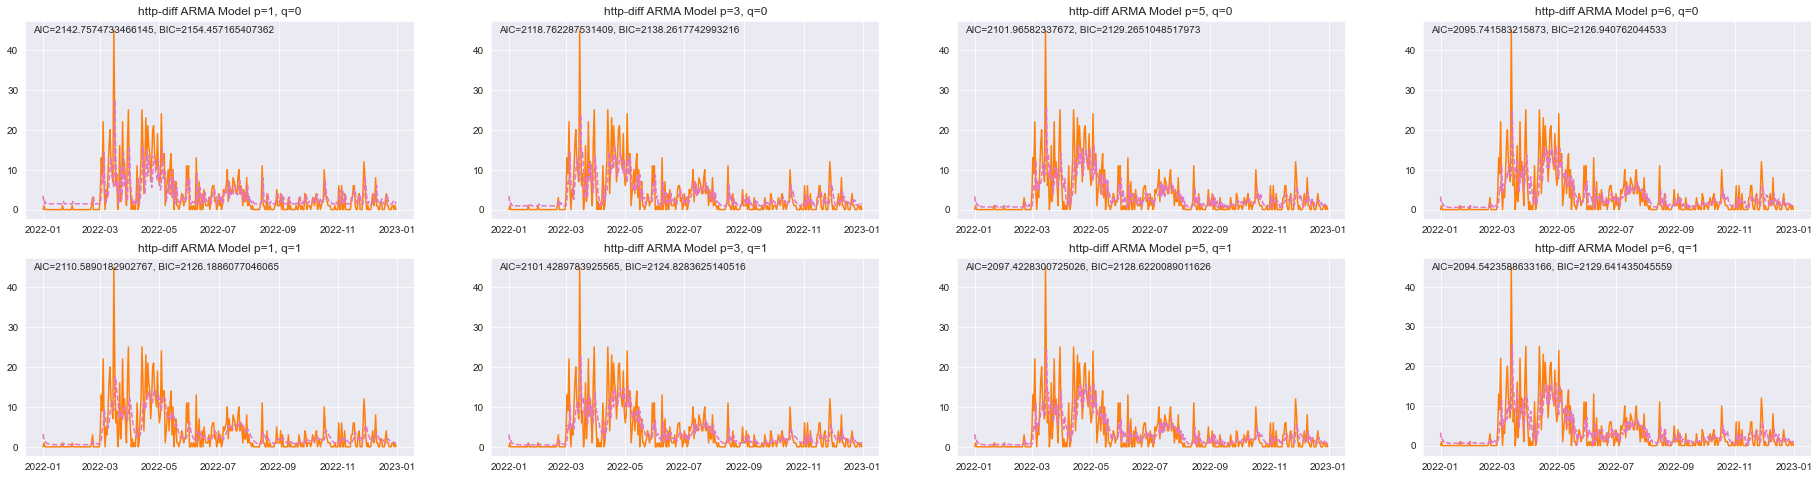

In [39]:
# Try out different ARMA terms
ar_orders = [1,3,5,6]
ma_orders = [0,1]

# Type and color
i = 1
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 0, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From these plots we see that the model with the lowest AIC is where $p=6$ and $q=1$, however the model with the lowest BIC is where $p=3$ and $q=1$.  Depending on whether we want to prioritize accuracy at the expense of using more data points for fitting, we would either choose the 6th or the 3rd order models for this blocking type.  We can conclude however that a moving average term does make a slight difference on model accuracy, and that there are potentially 3rd order to 6th order terms that have a decent impact on model prediction.

In [40]:
fitted_models[6][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              http-diff   No. Observations:                  365
Model:                 ARIMA(6, 0, 1)   Log Likelihood               -1038.271
Date:                Mon, 17 Mar 2025   AIC                           2094.542
Time:                        02:24:49   BIC                           2129.641
Sample:                    01-01-2022   HQIC                          2108.491
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2879      1.981      1.659      0.097      -0.596       7.171
ar.L1         -0.0463      0.176     -0.263      0.793      -0.392       0.299
ar.L2          0.1937      0.086      2.245      0.025       0.025       0.363
ar.L3          0.1567      0.047      3.313      0.001       0.064       0.249
ar.L4          0.0414      0.045      0.929      0.353      -0.046       0.129
ar.L5          0.1431      0.039      3.689      0.000       0.067       0.219
ar.L6          0.2551      0.052      4.928      0.000       0.154       0.357
ma.L1          0.4498      0.188      2.397      0.017       0.082       0.818
sigma2        17.2590      0.605     28.518      0.000      16.073      18.445
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5145.02
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the case of the `http-fail`, there are peaks at periods of 1, 2, and 3 in the partial autocorrelation factor plots, so we test out these in the AR terms.

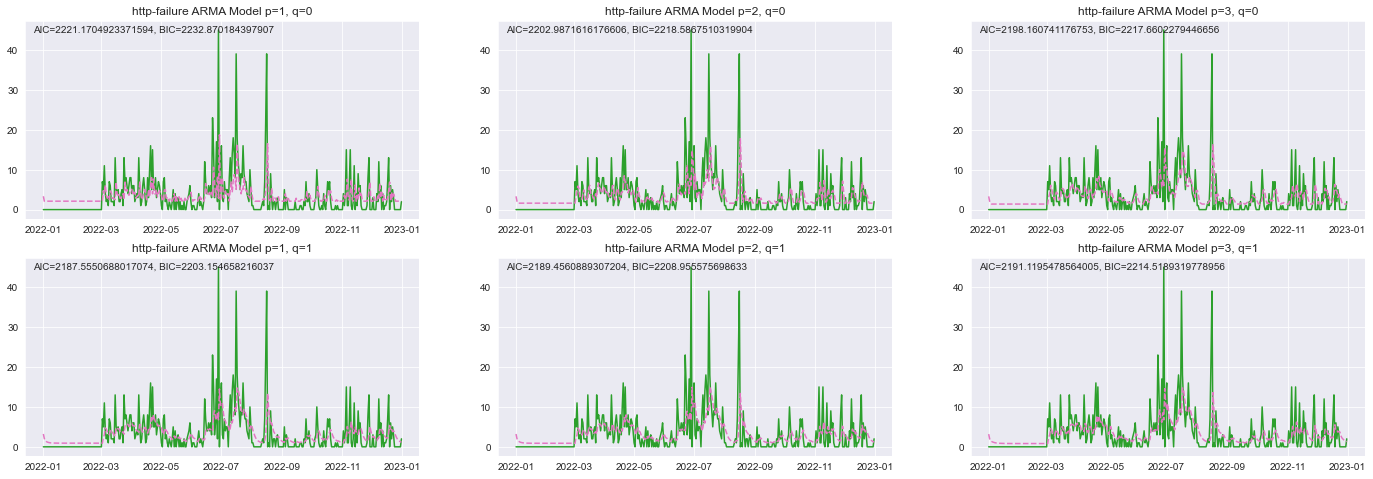

In [41]:
# Try out different ARMA terms
ar_orders = [1,2,3]
ma_orders = [0,1]

# Type and color
i = 2
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 0, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From these plots we can conclude that the $p=1$, and $q=1$ model has both the lowest AIC and BIC, likely drawing the same conclusions as the `dns` blocking model.  It is likely that the data for this test depends only on its nearest neighbor in the time series.

In [42]:
fitted_models[1][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           http-failure   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1089.778
Date:                Mon, 17 Mar 2025   AIC                           2187.555
Time:                        02:24:59   BIC                           2203.155
Sample:                    01-01-2022   HQIC                          2193.755
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2185      1.488      2.163      0.031       0.302       6.135
ar.L1          0.9166      0.029     31.530      0.000       0.860       0.974
ma.L1         -0.7067      0.037    -19.358      0.000      -0.778      -0.635
sigma2        22.9265      0.742     30.893      0.000      21.472      24.381
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              7327.69
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             3.47
Prob(H) (two-sided):                  0.03   Kurtosis:                        23.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Finally, for the `tcp_ip` blocking models, we have to use an integration term $d=1$ due to the fact that it is not unlikely that the 0th order data is non-stationary.  Therefore the integration term set to 1 will consider the first order difference to be the stationary set.  There are peaks in the partial autocorrelation plots at 1, 2, 8, and 10 which we test with the AR terms of the model.

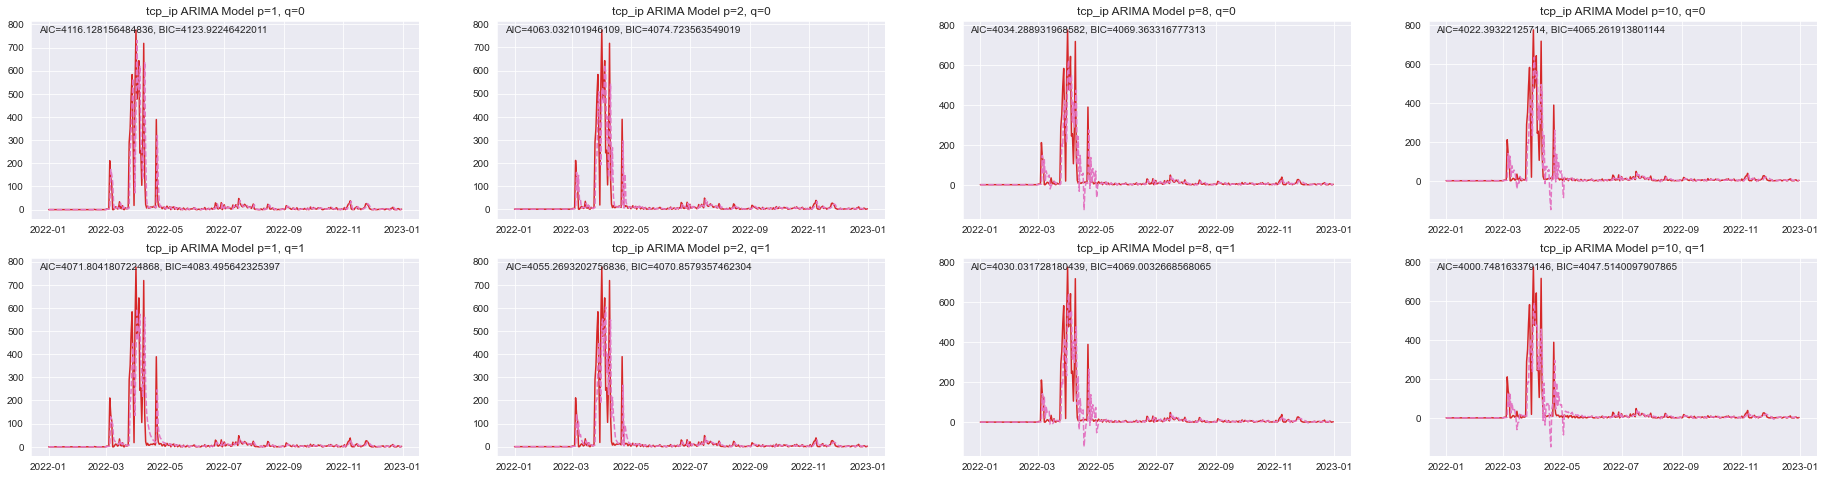

In [43]:
# Try out different ARMA terms
ar_orders = [1,2,8,10]
ma_orders = [0,1]

# Type and color
i = 3
typ = tdf.columns[i]
color = palette[i]
outcol = palette[len(tdf.columns)+2]

# Get data
d = tdf[typ]

# Set plot options
plt.rcParams['figure.figsize'] = [8*len(ar_orders), 4*len(ma_orders)]

# Loop through all models
fitted_models = {}
#plt.figure(figsize=(12*len(ma_orders), 4*len(ar_orders)))
fig, axes = plt.subplots(len(ma_orders), len(ar_orders), sharex=False)
for c, ar in enumerate(ar_orders):
    fitted_models[ar] = {}
    for r, ma in enumerate(ma_orders):
        ar_model = ARIMA(d, order=(ar, 1, ma))
        ar_model_fit = ar_model.fit()
        fitted_models[ar][ma] = ar_model_fit
        axes[r,c].plot(d, color=color)
        axes[r,c].plot(ar_model_fit.fittedvalues, color=outcol, linestyle='--')
        axes[r,c].set_title(f'{typ} ARIMA Model p={ar}, q={ma}') #, AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}')
        axes[r,c].text(0.02,0.98, f'AIC={ar_model_fit.aic}, BIC={ar_model_fit.bic}', ha='left', va='top', transform=axes[r,c].transAxes)

From these plots we can conclude that the best model is where $p=10$ and $q=1$ since this is where both AIC and BIC are the lowest.  This model captures more of the chaotic nature during the anomalous spike event with its higher order terms, but also overshoots those values in order to fit them.

In [44]:
fitted_models[10][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 tcp_ip   No. Observations:                  365
Model:                ARIMA(10, 1, 1)   Log Likelihood               -1988.374
Date:                Mon, 17 Mar 2025   AIC                           4000.748
Time:                        02:25:09   BIC                           4047.514
Sample:                    01-01-2022   HQIC                          4019.335
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5196      0.037     14.025      0.000       0.447       0.592
ar.L2         -0.1701      0.023     -7.425      0.000      -0.215      -0.125
ar.L3          0.2824      0.033      8.519      0.000       0.217       0.347
ar.L4         -0.0470      0.033     -1.427      0.154      -0.112       0.018
ar.L5          0.1842      0.032      5.723      0.000       0.121       0.247
ar.L6          0.0578      0.033      1.728      0.084      -0.008       0.123
ar.L7          0.0662      0.043      1.537      0.124      -0.018       0.151
ar.L8          0.0756      0.035      2.137      0.033       0.006       0.145
ar.L9         -0.0832      0.040     -2.070      0.038      -0.162      -0.004
ar.L10        -0.2875      0.025    -11.326      0.000      -0.337      -0.238
ma.L1         -0.9076      0.027    -33.571      0.000      -0.961      -0.855
sigma2      3232.7767     91.481     35.338      0.000    3053.477    3412.076
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              3823.43
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Results, Analysis, and Discussion

*Your project should take all the visualization and modeling
and attempt to draw conclusions from it. What is the evidence for your conclu-
sions? What is the evidence against your conclusions? What are the limitations
of your analysis? What other data would you want to collect in order to make
a better decision?*

The most interesting results that were discovered throughout this project were done through exploratory data analysis and then testing our assumptions of the data through modeling and statistical testing.  Our intial assumptions about what might seem interesting were actually completely wrong after seeing the Croatia 2022 data which became an unexpected central focus.


### Anomalies

From our anomaly detection method, we determined 3 unique regions of interest with different distributions of blocking events in each.  Through the two sample Z-Test within and outside of these ranges we can say that:

* All blocking events in region **(a)** likely do not have the same mean as outside of the region
* `http_diff` and `tcp_ip` events within **(b)** are likely to not have the same mean as outside of this range, but nothing can be said confidently of the other two methods
* `http_diff` and `dns` events within **(c)** are likely to not have the same mean as outside of this range, but nothing can be said confidently of the other two methods

We recognize that there is a caveat to running the two sample Z-Test on our data, since the data is not likely completely independent and normally distributed.  However what we can conclude is that through the later plots of autocorrelations, most of the blocking methods lose self-similarity after a period of $7$ days or so, which means that localized events in time periods longer than this are likely to be able to have their means tested against each other.  We also are testing sample sizes greater than $30$ datapoints which makes it more likely for the data to be normally distributed through the Central Limit Theorem, especially since there is very little to no seasonality observed in the data itself.  If there were more regular spikes at intervals in the partial correlation plots for each of the blocking types, it would be more likely that we couldn't conclude much about the Z-Tests, however it does provide an interesting point of reference for further exploration.


### Model Analysis

From our models, we can make the conclusion that the `tcp_ip` blocking events are most likely non-stationary in the time series data.  This means that the `tcp_ip` blocking events likely are a more complex function of time, and specifically a 1st order function.  This is evidenced by the fact that it reaches stationarity in the first order differential.

After running different combinations of ARMA and ARIMA models, we have determined the following characteristics of the different blocking events through the models that produced the lowest AIC and BIC values:

* `dns` - Likely the first order autoregression and first order moving average are decent predictors of future behavior, meaning that one step in the past is likely to vary in the same direction as the future time step.
* `http_diff` - Likely there are 3rd to 6th order terms that allow predicting future behavior fairly well, and including a moving average also further improves model accuracy.
* `http_fail` - As with `dns`, likely the first order autoregression and first order moving average are decent predictors of future behavior.
* `tcp_ip` - There is much more chaotic and higher order behavior occurring due to the fact that the $p=10$ model performed the best.  The anomalous nature of the region of interest suggests that this is a much more interesting and dynamic blocking event type.

From our models, we can characterize these blocking event types, however it would be more interesting to explore the inter-country relationships using one model to try to test the behavior of another country's data.  This would likely not produce super accurate results, but might indicate whether there is any predictive power from what we see in Croatia in 2022 on another country with similar or differing censorship activity.  This would require that we collect even more data from a larger pool of date ranges and countries which was just not feasible for the scope of this project.


### Discussion

In order to make full conclusions about the anomalous behavior of Croatia during 2022, we would need to have a larger context of potential behaviors, specifically around `tcp_ip` blocking events in different countries.  Just looking at Belarus and Nepal during those time periods was at least a glimpse of the distributions of a country with known censorship history, and a country with potential censorship, however an extended series of date ranges would provide additional insights.

There is just not enough data to make a solid conclusion about what exactly is happening in the anomalous regions we detected, but they are at least an interesting set of targets for further analysis.

Additionally, we would like to reach out to OONI to provide them with these findings and get their opinions on what could be happening in the data to avoid any false accusations.

## Impact

*Finally, your project must discuss the impact that your meth-
ods or conclusions could have if adopted in the real world. What does your
analysis suggest should be done? Do you agree? Who would be impacted, and
how? Reducing costs? Increasing or decreasing bias? Shifting power? What
would be the impact if your models were accurate? What would be the impact
if they weren’t?*

We believe this data analysis to have significant impact. Censorship is dangerous, and with the political climate of the world heading in the direction it currently is, we need to fight to prevent censorship at any turn. This style of data analysis is important in that fight. To this day, no one has been able to create a perfect automated censorship detection system. Most systems have to run some form of detection set up to never have false negatives. The system then sets up an alarm which will cause an expert to analyze the data to determine whether real censorship is taking place or not. 

If our analysis is correct, there is a non-zero chance of a major temporal censorship event occuring in an open country which has not yet been reported on. This would have major implications politically. Because of this significance, we cannot make any accusations without following up. One of our group members is in contact with OONI for other research purposes. He has been in communication with the CTO of OONI for other projects. He will ask the CTO about this later. If our analysis is correct, this is a major event that needs to be made public.